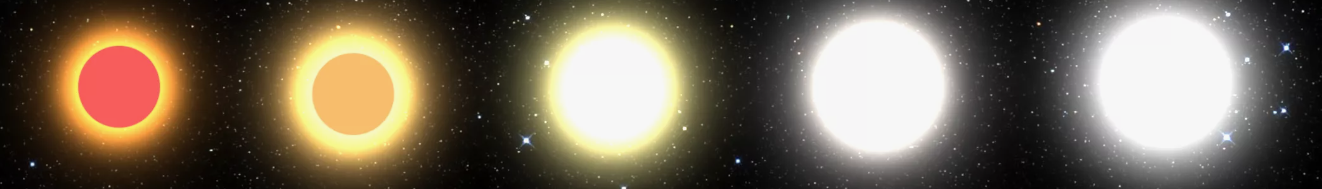

# Прогнозирование температуры звезды

# Постановка задачи

Задача от обсерватории: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами: закон смещения Вина, закон Стефана-Больцмана, спектральный анализ.\
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики:
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
- Тип...


| Тип звезды	|Номер, соответствующий типу |
| ---           | ---            |
| Коричневый карлик	| 0 |
| Красный карлик	| 1 |
| Белый карлик	| 2 |
| Звёзды главной последовательности	| 3 |
| Сверхгигант	| 4 |
| Гипергигант	| 5 |

## Загрузка данных

In [1]:
#pip install phik

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import phik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
from math import ceil, sqrt
from termcolor import colored
import random

In [3]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

In [4]:
try:
    data = pd.read_csv('../../18 модели и алгоритмы Нейронные сети/project/6_class.csv')
except:
    try:
        data = pd.read_csv('/datasets/6_class.csv')
    except:
        data = pd.read_csv('https://code.s3.yandex.net/datasets/6_class.csv')

## Предобработка и анализ данных

In [5]:
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [7]:
# наличие пропусков
data.isnull().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [8]:
# наличие полных дубликатов
data.duplicated().sum()

0

In [9]:
# кол-во дубликатов в столбце 'Unnamed: 0'
data['Unnamed: 0'].duplicated().sum()

0

In [10]:
# проверка на неявные дубликаты в признаке 'Star color'
np.sort(data['Star color'].unique())

array(['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ',
       'Blue-White', 'Blue-white', 'Orange', 'Orange-Red',
       'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish',
       'Yellowish', 'Yellowish White', 'white', 'yellow-white',
       'yellowish'], dtype=object)

In [11]:
# убираем пробелы по краям и переводим в нижний регистр
data['Star color'] = data['Star color'].str.lower().str.strip()

In [12]:
# проверка на неявные дубликаты в признаке 'Star color'
data['Star color'].value_counts()

red                   112
blue                   56
blue-white             27
blue white             14
white                  10
yellow-white            8
yellowish               3
yellowish white         3
whitish                 2
orange                  2
pale yellow orange      1
white-yellow            1
orange-red              1
Name: Star color, dtype: int64

Корректируем неявные дубликаты. Некоторые позиции (например, 'whitish'/'white') похожи, и без совместной работы с астрономом сложно сказать на сколько критично их объединение. Но с учётом единичного числа таких позиций, полагаю, их можно совместить.

In [13]:
data['Star color'].replace('blue white', 'blue-white', inplace=True)
data['Star color'].replace(['yellowish', 'yellowish white', 'white-yellow'] , 'yellow-white', inplace=True)
data['Star color'].replace('whitish', 'white', inplace=True)
data['Star color'].replace(['orange-red', 'pale yellow orange'] , 'orange', inplace=True)

In [14]:
# удаление лишнего столбца, дублирующего индексы
data.drop('Unnamed: 0', axis=1, inplace=True)

### Графический анализ признаков

In [15]:
def description(feature):
    '''По Series-признаку рисует диаграмму размаха, гистограмму и табличку с точным статистиками'''
    f, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), 
                                                        "width_ratios":  (0.85, 0.15)}, figsize=(9,3.5))
    sns.boxplot(x=feature, ax=ax[0,0])
    sns.histplot(x=feature, bins=100, ax=ax[1,0], element="step",alpha=0.3)
    ax[0,1].remove()
    table(data=feature.describe(), ax=ax[1,1], loc='right', colWidths=[1.8])
    
    ax[0,0].set(yticks=[], xlabel=None)
    sns.despine(ax=ax[1,0])
    sns.despine(ax=ax[0,0], left=True)
    plt.axis('off')

#### Temperature

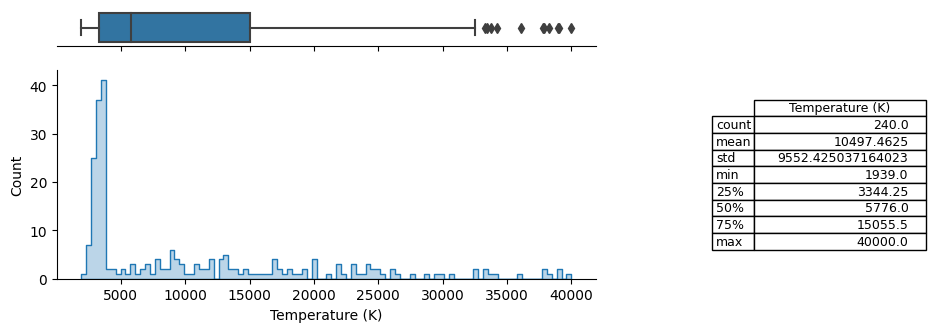

In [16]:
description(data['Temperature (K)'])

Диапазон значений в пределах допустимого. [Википедия](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%B7%D0%B8%D0%BA%D0%B0_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4#:~:text=%D0%A1%D0%B0%D0%BC%D1%8B%D0%B5%20%D0%B3%D0%BE%D1%80%D1%8F%D1%87%D0%B8%D0%B5%20%D0%B7%D0%B2%D0%B5%D0%B7%D0%B4%D1%8B,%D0%BD%D0%B8%D0%B6%D0%B5%203600%20%D0%9A.)

#### Luminosity

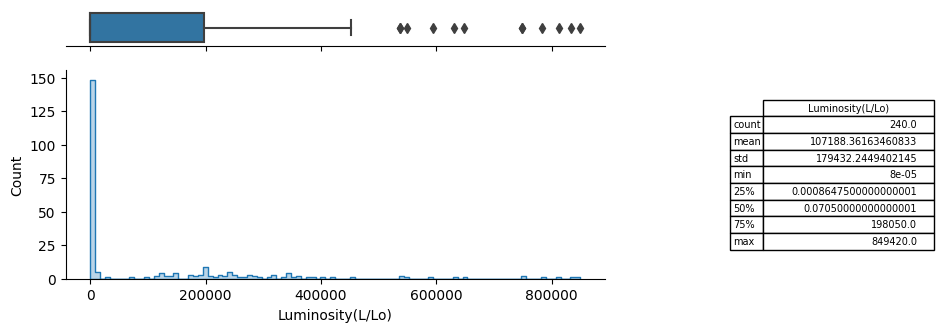

In [17]:
description(data['Luminosity(L/Lo)'])

Диапазон значений в пределах допустимого. [Википедия](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4_%D1%81_%D0%BD%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B5%D0%B9_%D1%81%D0%B2%D0%B5%D1%82%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%D1%8E#:~:text=%D0%A1%D0%B2%D0%B5%D1%82%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%20(%D0%A1%D0%BE%D0%BB%D0%BD%D1%86%D0%B5%20%3D%201))

#### Radius

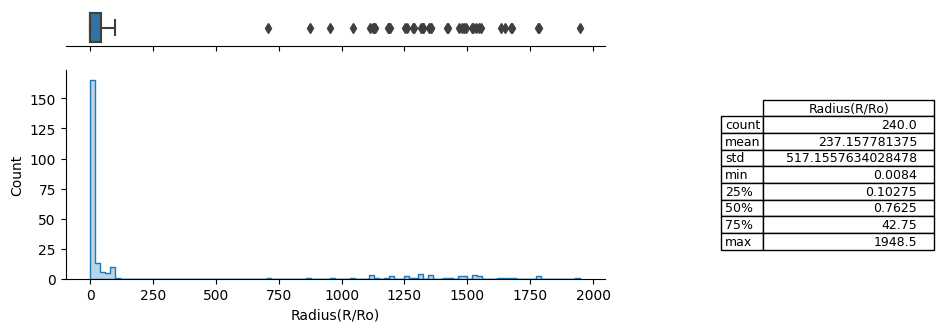

In [18]:
description(data['Radius(R/Ro)'])

Диапазон значений в пределах допустимого. [Википедия](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%BA%D1%80%D1%83%D0%BF%D0%BD%D0%B5%D0%B9%D1%88%D0%B8%D1%85_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4#:~:text=%D0%A0%D0%B0%D0%B4%D0%B8%D1%83%D1%81%20%D0%BF%D0%BE%20%D1%81%D0%BE%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%BC%20%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%D0%BC)

#### Absolute magnitude

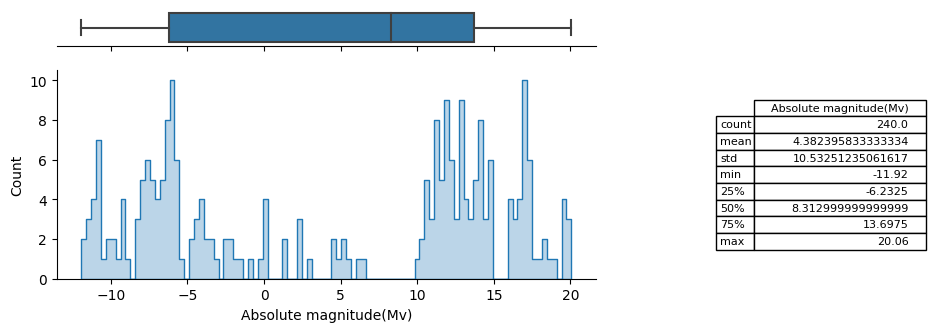

In [19]:
description(data['Absolute magnitude(Mv)'])

Диапазон значений в пределах допустимого. [Википедия](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4_%D1%81_%D0%BD%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B5%D0%B9_%D1%81%D0%B2%D0%B5%D1%82%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%D1%8E#:~:text=%D0%92%D0%B8%D0%B4%D0%B8%D0%BC%D0%B0%D1%8F%20%D0%B7%D0%B2%D1%91%D0%B7%D0%B4%D0%BD%D0%B0%D1%8F%20%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D0%B0-,%D0%90%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D0%B0%D1%8F%20%D0%B7%D0%B2%D1%91%D0%B7%D0%B4%D0%BD%D0%B0%D1%8F%20%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D0%B0,-%D0%A1%D0%B2%D0%B5%D1%82%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C%20(%D0%A1%D0%BE%D0%BB%D0%BD%D1%86%D0%B5), [Ab-news.ru (science tech portal)](https://ab-news.ru/absolyutnaya-i-otnositelnaya-zvezdnaya-velichina/#:~:text=%D0%90%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D0%B5%20%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D1%8B%20%D0%B7%D0%B2%D0%B5%D0%B7%D0%B4%20%D0%BE%D0%B1%D1%8B%D1%87%D0%BD%D0%BE%20%D0%BA%D0%BE%D0%BB%D0%B5%D0%B1%D0%BB%D1%8E%D1%82%D1%81%D1%8F%20%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%20%D0%BE%D1%82%20%2D10%20%D0%B4%D0%BE%20%2B20.)

#### Star type

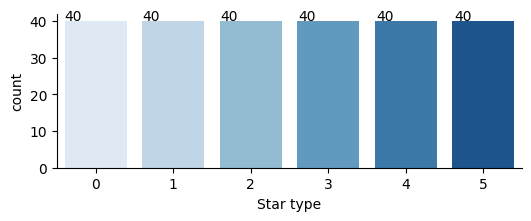

In [20]:
plt.figure(figsize=(6,2))
ax=sns.countplot(x=data['Star type'], palette='Blues')
sns.despine()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Подозрительно ровное количество звёзд разного типа. Видимо, так решили составители датасета.

#### Star color

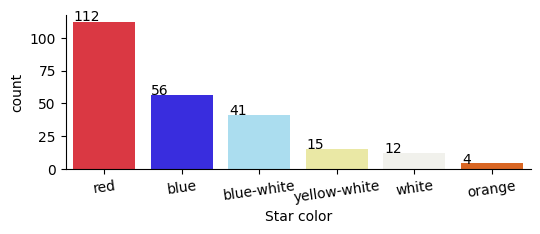

In [21]:
plt.figure(figsize=(6,2))
ax=sns.countplot(x=data['Star color'], order=data['Star color'].value_counts().index, 
                 palette=['#f51d2c','#1f0ffc','#a0e3fa','#f5f39a','#f2f2eb','#f75e05'])
ax.tick_params(axis='x', labelrotation=8)
sns.despine()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

### Взаимосвязь признаков

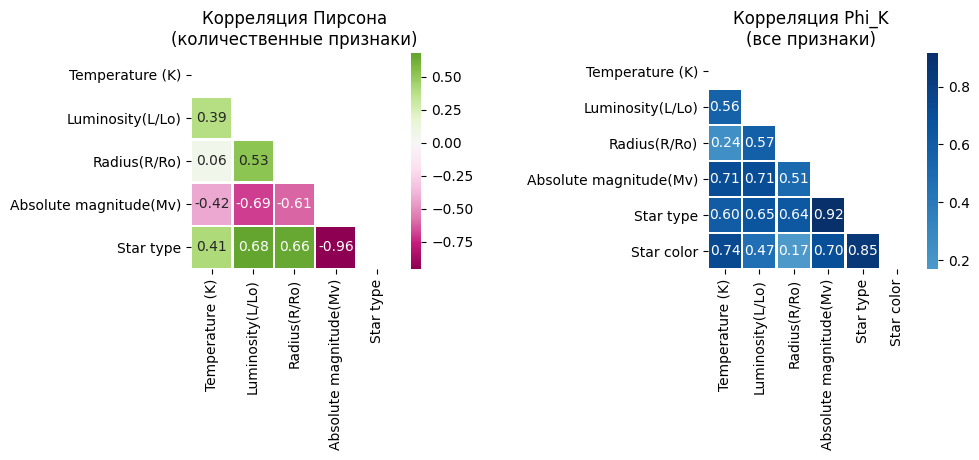

In [22]:
f, ax = plt.subplots(1,2, figsize=(10,2.8), gridspec_kw={"wspace": 1})
matrix = np.triu(data.corr())
sns.heatmap(data.corr(),annot=True,cmap='PiYG',center=0, linewidth=1, fmt='.2f', mask=matrix, ax=ax[0])

data_phik = data.phik_matrix(interval_cols=['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
                                            'Absolute magnitude(Mv)', 'Star type'])
matrix = np.triu(data_phik)
sns.heatmap(data_phik, annot=True, cmap='Blues', center=0, linewidth=1, fmt='.2f', mask=matrix, ax=ax[1])
ax[0].set_title('Корреляция Пирсона\n(количественные признаки)'); ax[1].set_title('Корреляция Phi_K\n(все признаки)') 
plt.show()

**Star type** будет удалён из обучающей выборки, так как мультиколлинеарен признакам **Absolute magnitude** и **Star color**.<br>
Большинство признаков обладают достаточно высокими средними корреляциями. Например, **Absolute magnitude**, **Luminosity** и **Radius** - физически взаимосвязанные виличины.

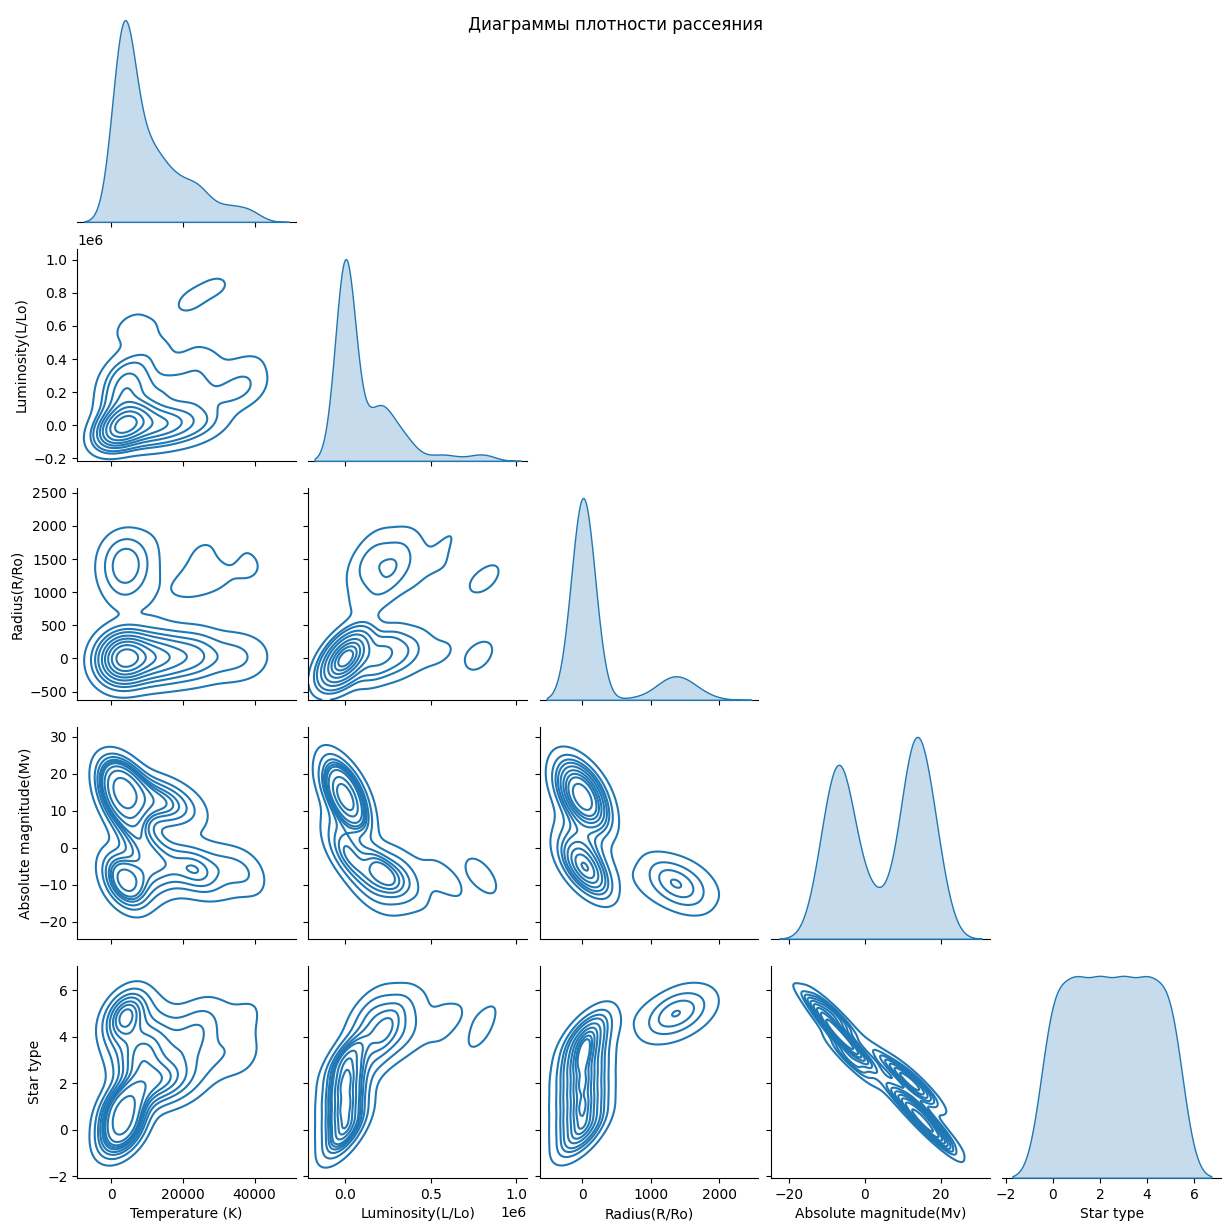

In [23]:
ax=sns.pairplot(data, kind='kde', corner=True)
ax.fig.suptitle('Диаграммы плотности рассеяния')
plt.show()

Диаграммы подтверждают выводы по коэффициентам корреляции.

## Подготовка данных к построению модели

Исходный датасет делится на 2 части: train, test. Лучшая модель подбирается с помощью train (обучение) и test (валидация).\
Для итогового единоразового тестирования модели датасета нет, из-за небольшого исходного датасета (240 объектов).

In [24]:
# разбиваем df на обучающую и тестовую выборки; признаки и целевой признак
X_train_, X_test_, y_train, y_test = train_test_split(data.drop(['Temperature (K)','Star type'], axis=1), 
                                                      data['Temperature (K)'], test_size=0.25, random_state=12345,
                                                      stratify=data['Star color'])

In [25]:
# проверка размеров выборок
print(X_train_.shape, y_train.shape)
print(X_test_.shape,  y_test.shape)

(180, 4) (180,)
(60, 4) (60,)


In [26]:
# нормализация количественных признаков
scaler = StandardScaler()
scaler.fit(X_train_.drop('Star color', axis=1))

X_train_scaled = scaler.transform(X_train_.drop('Star color', axis=1))
X_test_scaled  = scaler.transform(X_test_.drop('Star color', axis=1))

In [27]:
# OHE-кодирование категориального признака
encoder = OneHotEncoder(drop='first', handle_unknown = 'ignore')
encoder.fit(X_train_[['Star color']])

X_train_ohe = encoder.transform(X_train_[['Star color']]).toarray()
X_test_ohe  = encoder.transform(X_test_ [['Star color']]).toarray()

In [28]:
# объединение в одно множество нормализованных и закодированного признаков; преобразование в тензор
X_train = torch.Tensor(np.concatenate([X_train_scaled, X_train_ohe], axis=1))
X_test  = torch.Tensor(np.concatenate([X_test_scaled, X_test_ohe], axis=1))

y_train = torch.Tensor(y_train.values)
y_test  = torch.Tensor(y_test.values)

## Построение базовой нейронной сети

#### Вариант 1 (8/3/1, Sigmoid, lr=0.1)

In [29]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [30]:
model = Net(8,3,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [31]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

In [32]:
def neural_net(l2_lambda=0):
    '''вычисляет минимальный RMSE в двойном цикле по эпохам и батчам; сообщает на какой эпохе достигнут лучший RMSE_test;
       выводит динамику изменения RMSE на графике;
       возможна регуляризация весов чере l2_lambda'''
    global prediction_test_best
    count_higher_rmse = 0
    df_rmse = pd.DataFrame(columns=['train', 'test'])
    for epoch in range(num_epochs):
        
        # случайная перестановка объектов
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx*batch_size
            
            # получение индексов текущего батча
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            optimizer.zero_grad()
            prediction = model.forward(X_train)
            loss_value = loss(prediction.flatten(), y_train)
            loss_value = loss_value + l2_lambda*sum(p.pow(2).sum() for p in model.parameters()) # добавленная регуляризация
            loss_value.backward()
            optimizer.step()
    
        # расчёт RMSE в конце каждой эпохи
        rmse_train = round(sqrt(loss_value)) 
        
        # расчёт RMSE на тестовой выборке; блок кода для расчёта метрик в режиме инференса
        with torch.no_grad():
            model.eval()
            prediction_test = model.forward(X_test)
            rmse_test = round(sqrt(loss(prediction_test.flatten(), y_test)))
            model.train()
        
        # фиксирование начальных RMSE и предсказания на случай, если в самом начале попали в идеальное предсказание
        if epoch == 0:
            rmse_test_best = rmse_test
            prediction_test_best = prediction_test
            rmse_test_last = rmse_test             # техническое присвоение для начальной эпохи чтобы сработал if ниже
        
        # формирование df c RMSE-train/test на каждой 10-ой эпохе или последней
        if epoch%10 == 0 or epoch+1 == num_epochs:
            df_rmse = pd.concat([df_rmse, pd.DataFrame([[rmse_train, rmse_test]], [epoch], ['train', 'test'])])
        
        # прерывание цикла, если в течении 3 эпох подряд rmse_test увеличивается
        if rmse_test >= rmse_test_last and count_higher_rmse < 4:
            count_higher_rmse+=1
            rmse_test_last = rmse_test
        elif rmse_test < rmse_test_last:
            count_higher_rmse = 0
            rmse_test_best = rmse_test
            rmse_test_last = rmse_test
            prediction_test_best = prediction_test
        else:
            print(' '*50) # закрашивает последнее значение счётчика эпох
            f, ax = plt.subplots(1,2, gridspec_kw={"width_ratios": (0.8, 0.2)}, figsize=(10,3))
            df_rmse.plot(grid=True, title='RMSE на обучающей и тестовой выборках', xlabel='эпоха', ax=ax[0])
            plt.text(0, 0.75, f"Наименьшее \nRMSE_test={rmse_test_best} достигнуто на {epoch-3}-ой эпохе.\
                     \n\nRMSE_train = {rmse_train}")
            plt.text(0, 0, f"num_epochs_max = {num_epochs}, \nbatch_size = {batch_size},\
                     \nlr = {optimizer.state_dict()['param_groups'][0]['lr']}, \nl2_lambda = {l2_lambda}", color='grey')
            plt.axis('off'); plt.show()
            break
        
        print (f"Вычисляется эпоха {epoch+1} из {num_epochs}", end='\r') # счётчик эпох

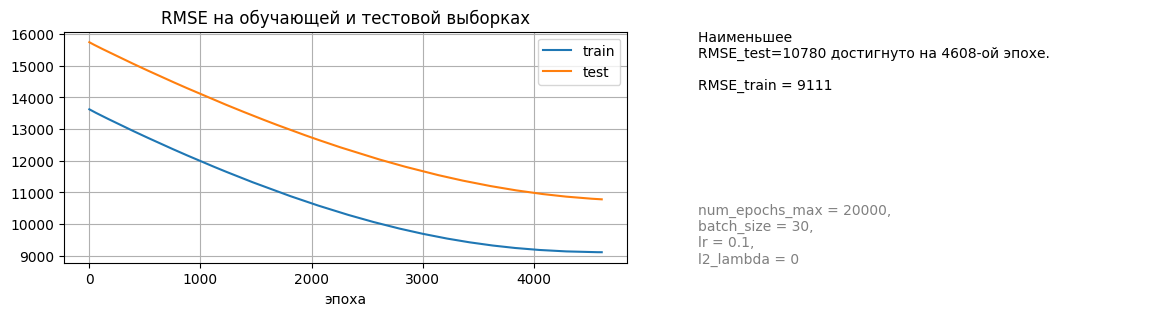

In [33]:
neural_net()

#### Вариант 2 (8/25/1, Sigmoid, lr=0.1)

In [34]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [35]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

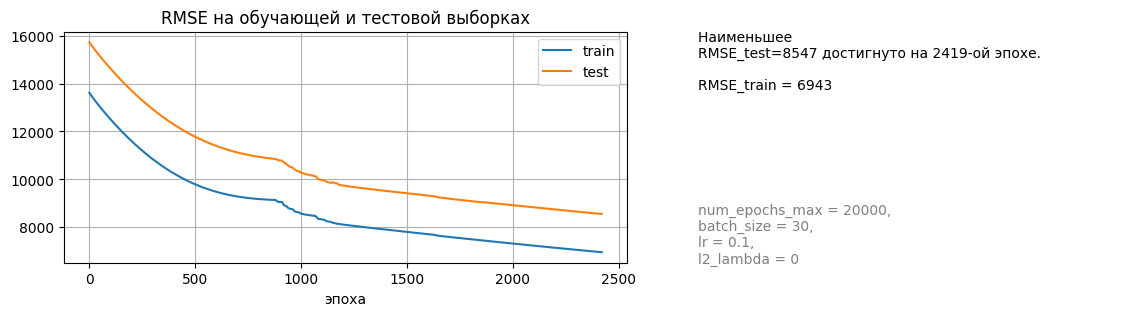

In [36]:
neural_net()

#### Вариант 3 (8/25/1, Tanh, lr=2)

In [37]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [38]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2)

In [39]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

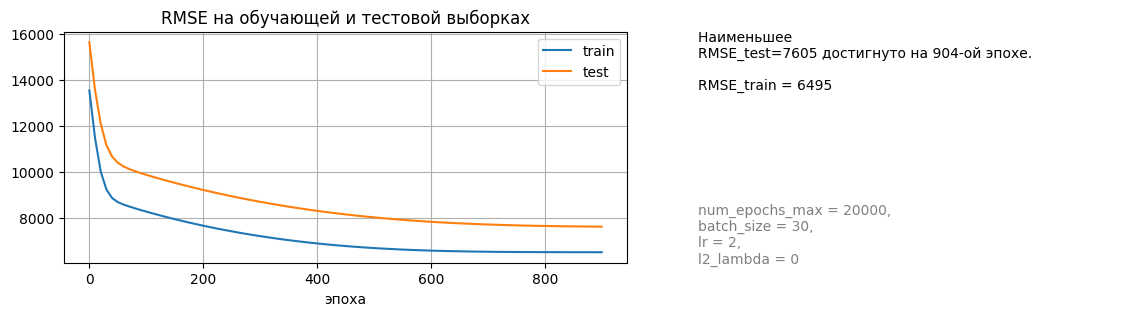

In [40]:
neural_net()

#### Вариант 4 (8/25/1, ReLU, lr=0.1)

In [41]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [42]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [43]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

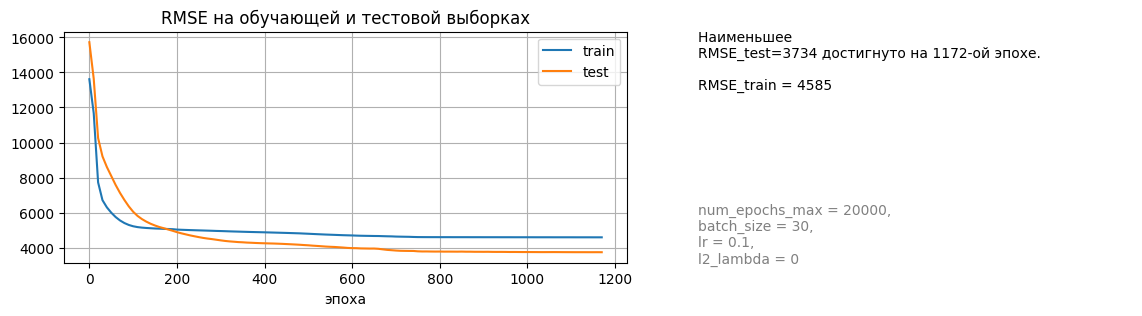

CPU times: total: 6.23 s
Wall time: 6.61 s


In [44]:
%%time
neural_net()

#### Вариант 5 (8/3/1, ReLU, lr=0.1)

In [45]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [46]:
model = Net(8,3,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [47]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

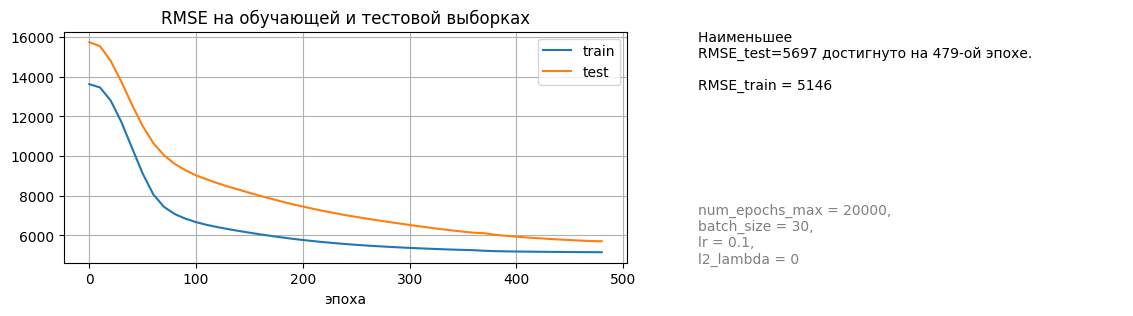

In [48]:
neural_net()

#### Вариант 6 (8/25/5/1, ReLU, Tanh, lr=2)

In [49]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [50]:
model = Net(8,25,5,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2)

In [51]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

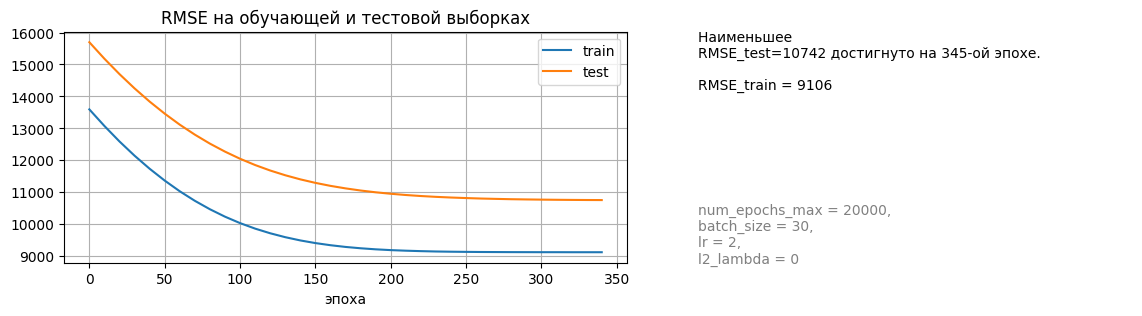

In [52]:
neural_net()

#### Вариант 7 (8/5/25/1, ReLU, Tanh, lr=3)

In [53]:
model = Net(8,5,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3)

In [54]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

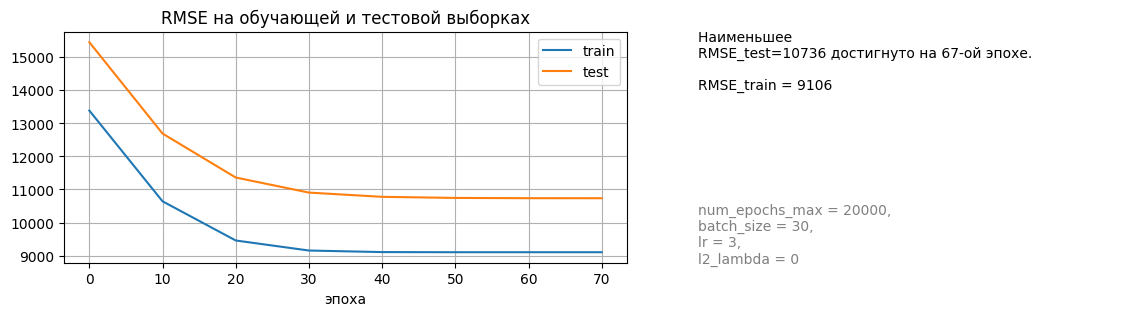

In [55]:
neural_net()

#### Вариант 8 (8/6/3/1, ReLU, Tanh, lr=1)

In [56]:
model = Net(8,6,3,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)

In [57]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

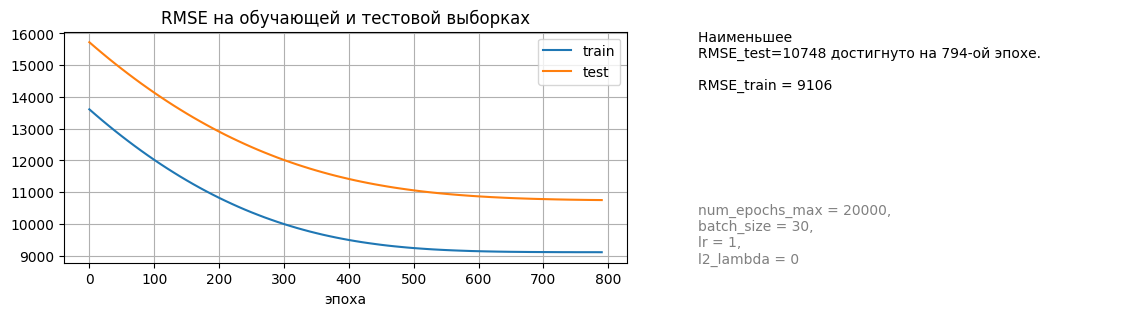

In [58]:
neural_net()

#### Вариант 9 (8/10/3/1, Sigmoid, ReLU, lr=0.1)

In [59]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [60]:
model = Net(8,10,3,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [61]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

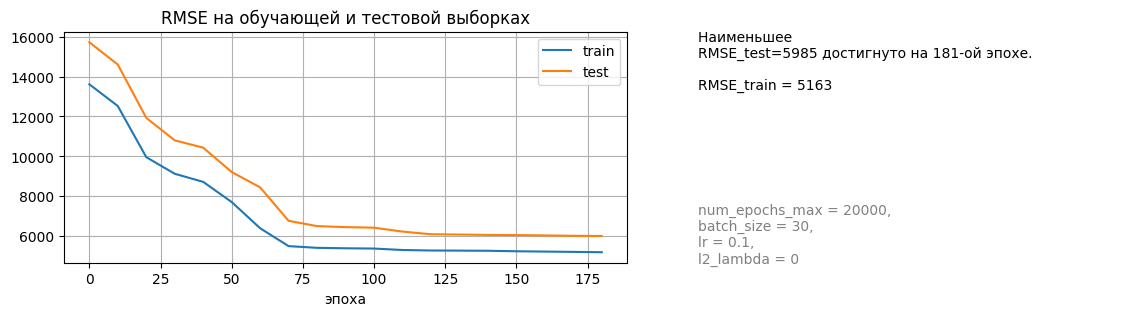

In [62]:
neural_net()

#### Вывод по подбору baseline

Наилучшие результат у модели:

* Вариант 4 (8/25/1, ReLU, lr=0.1) - RMSE_test = 3734 достигнуто на 1172 эпохе.

Её принимаем за baseline.

In [63]:
df_fact_prediction = pd.DataFrame(torch.cat((y_test.reshape(-1,1),prediction_test_best),axis=1).detach().numpy(), 
                                  columns=['Факт', 'Прогноз'])

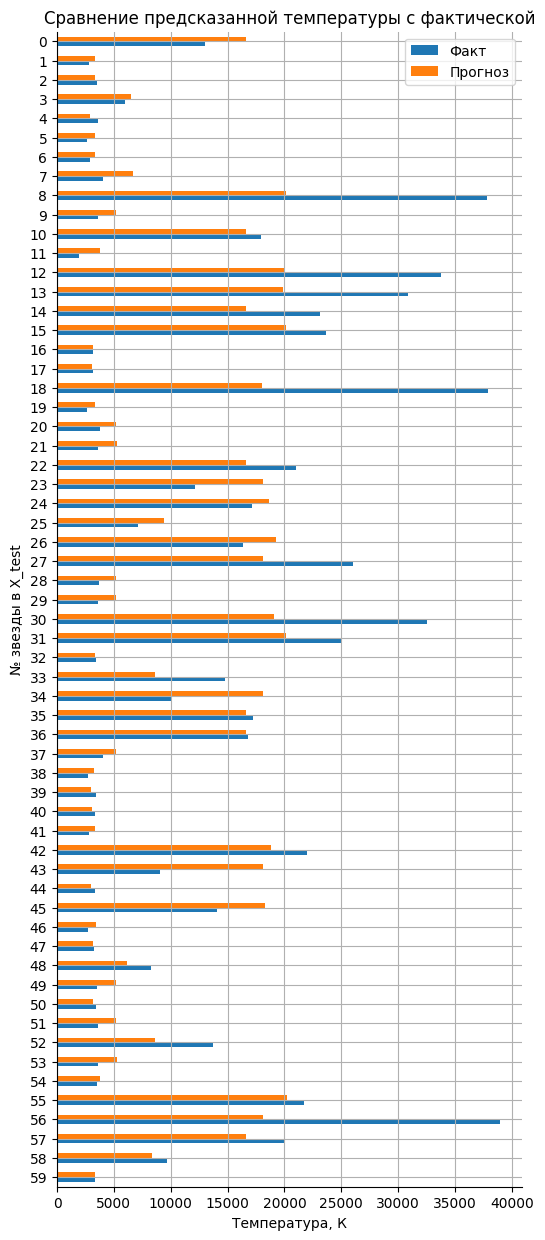

In [64]:
ax = df_fact_prediction.sort_index(ascending=False).plot(kind='barh', figsize=(6,15), grid=True)
ax.set(xlabel='Температура, К', ylabel='№ звезды в X_test', title = 'Сравнение предсказанной температуры с фактической')
sns.despine(ax=ax)

## Улучшение нейронной сети

### Инициализация параметров сети равномерным распределением

In [65]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in')
        nn.init.uniform_(self.fc1.bias, a=0,b=0.7)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.uniform_(self.fc2.bias, a=0, b=0.3)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [66]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [67]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

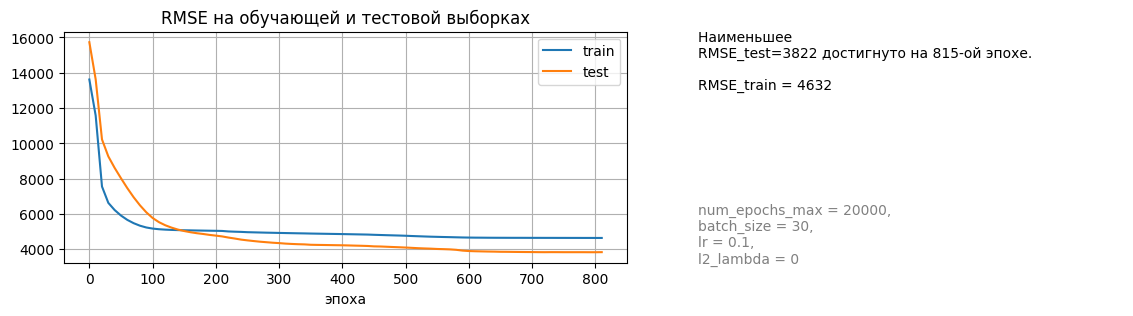

In [68]:
neural_net()

### Инициализация параметров сети нормальным распределением

In [69]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        nn.init.normal_(self.fc1.bias, mean=0.5, std=1.9)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=-0.8, std=0.01)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [70]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [71]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

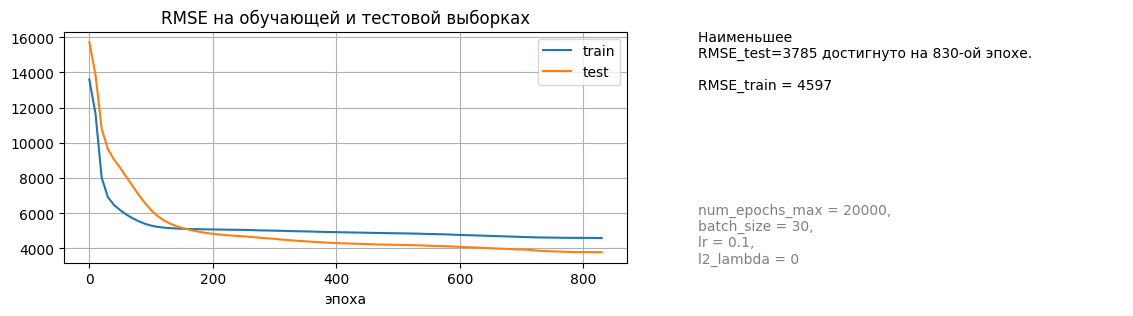

In [72]:
neural_net()

Инициализация не внесла улучшения. Изменения в пределах случайности.\
Для дальнейшей работы возьмём инициализацию нормальным распределением.

### Регуляризация весов

In [73]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

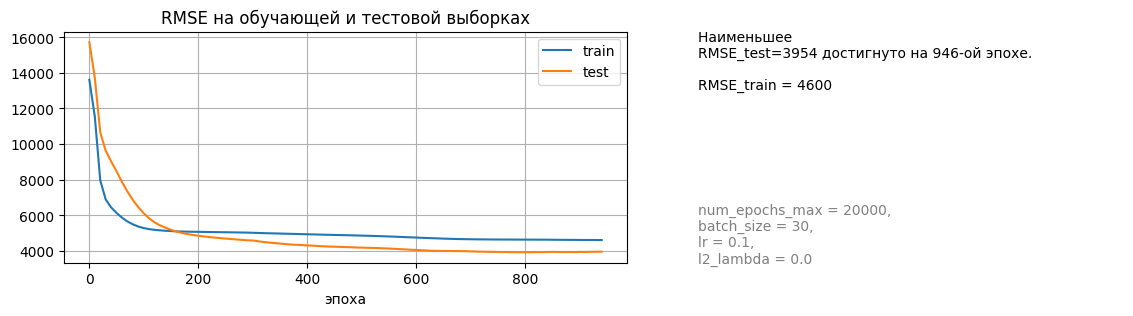

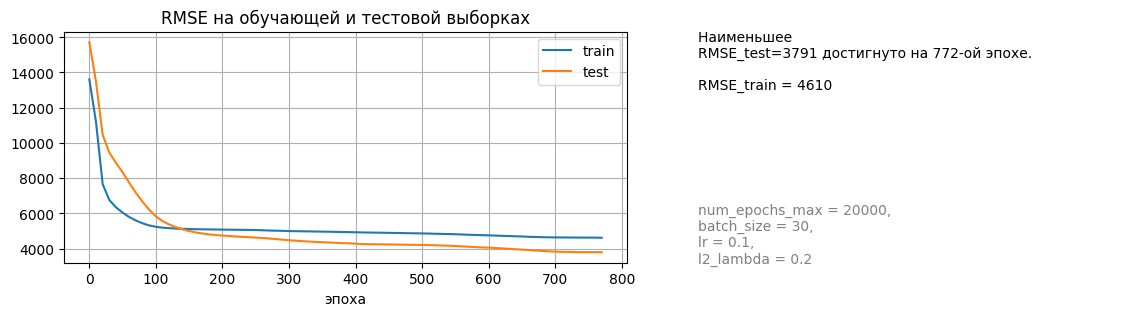

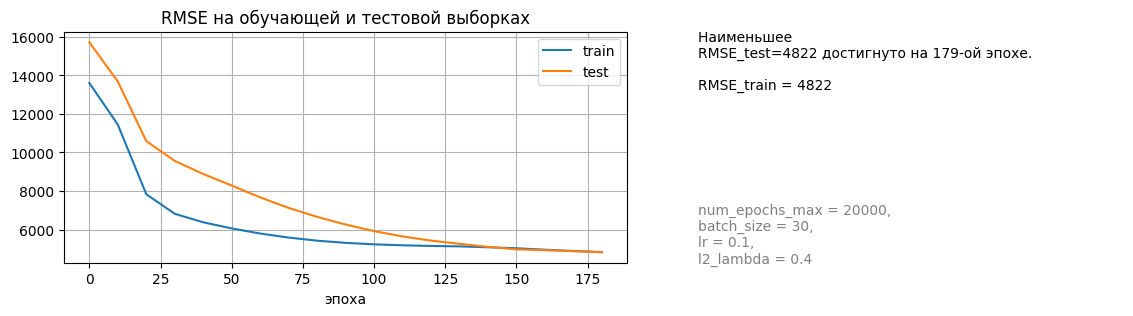

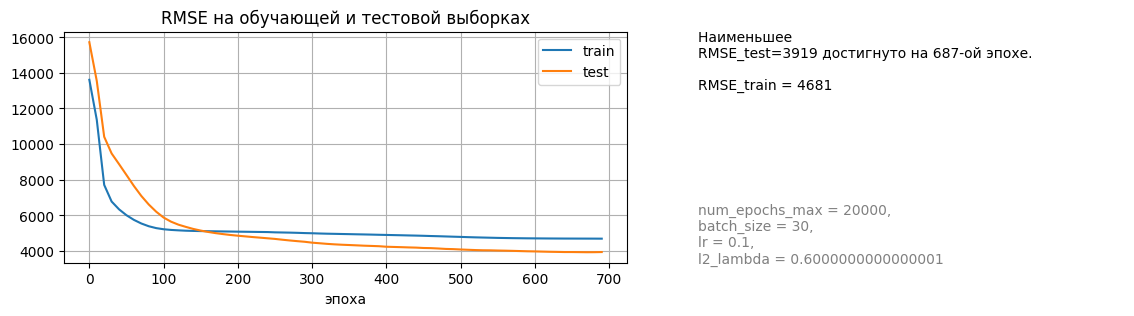

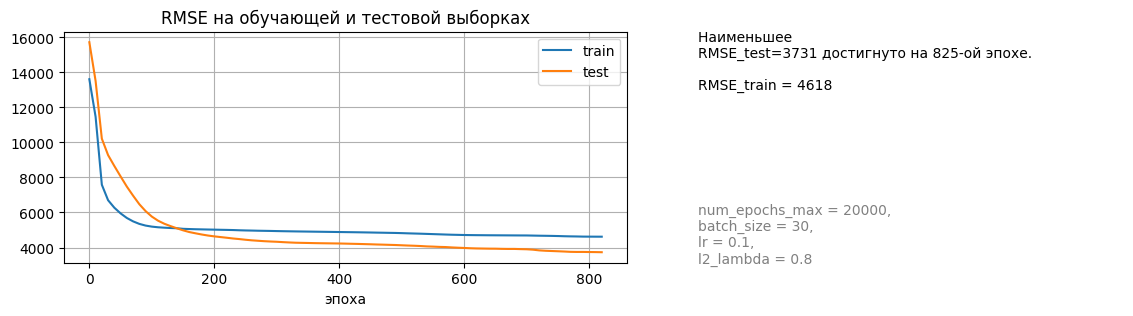

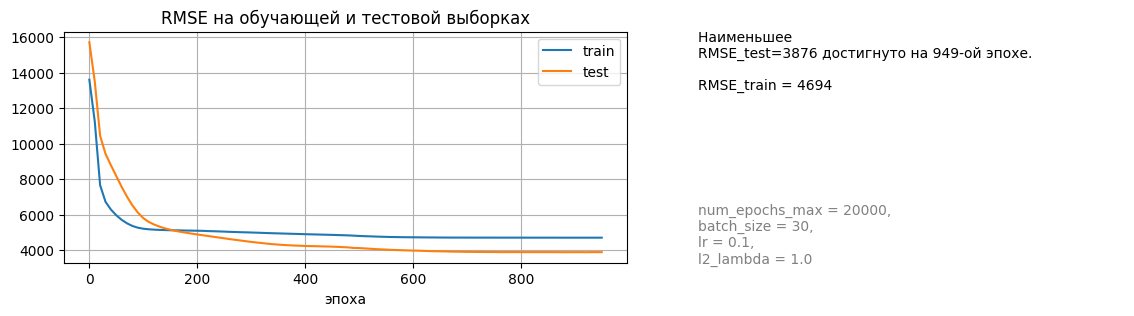

In [74]:
for _ in np.arange(0, 1.1, 0.2):
    model = Net(8,25,1)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    neural_net(l2_lambda = _)

Регуляризация не даёт улучшение метрики.\
В дальнейших экспериментах регуляризацию не используем (l2_lambda = 0).

### Batch normalization

In [75]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        nn.init.normal_(self.fc1.bias, mean=0.5, std=1.9)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=-0.8, std=0.01)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

In [76]:
model = Net(8,25,1)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [77]:
batch_size = 30
num_epochs = 20000
num_batches = ceil(len(X_train)/batch_size)

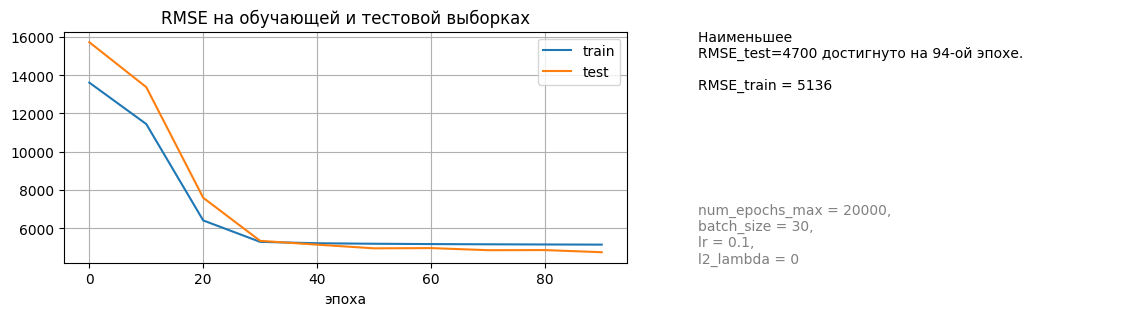

In [78]:
neural_net()

С использованием BatchNorm метрика ухудшилась. Использовать не будем.

### Dropout

In [79]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons, p_dropout):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.dp1 = nn.Dropout(p=p_dropout)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        nn.init.normal_(self.fc1.bias, mean=0.5, std=1.9)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=-0.8, std=0.01)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

p = 0.08
                                                  


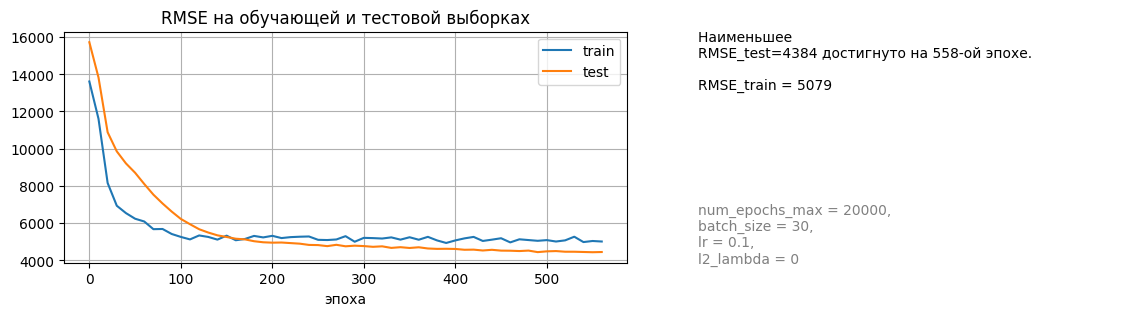

p = 0.38
                                                  


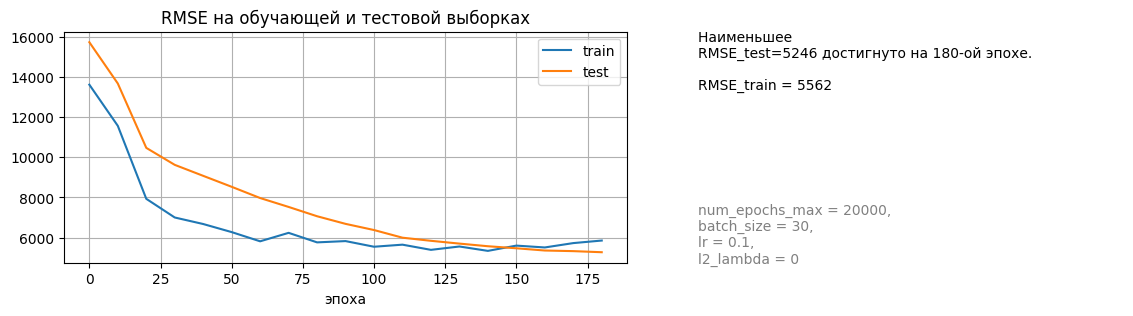

p = 0.6799999999999999
                                                  


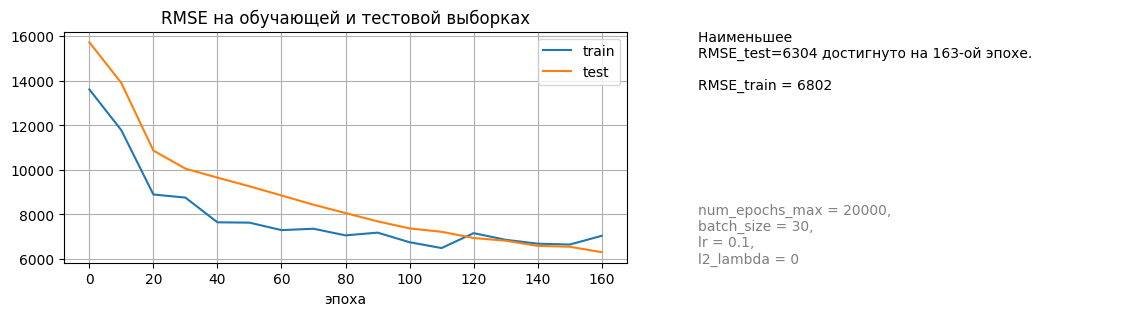

p = 0.9799999999999999
                                                  


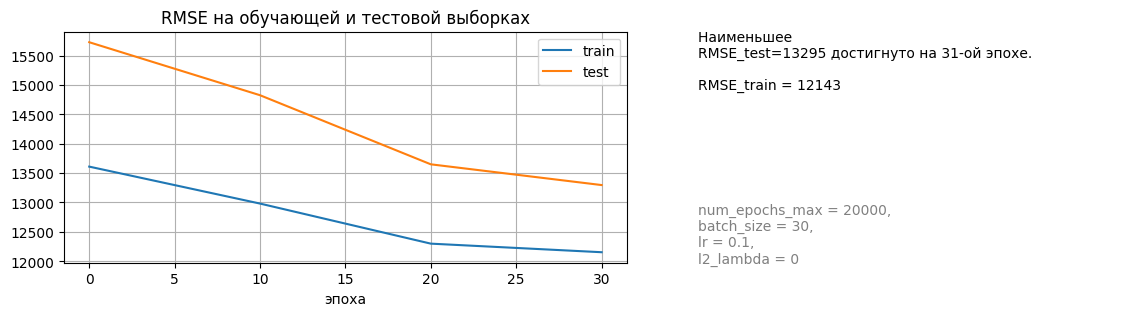

In [80]:
for p in np.arange(0.08, 1, 0.3):
    model = Net(8,25,1,p)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    batch_size = 30
    num_epochs = 20000
    num_batches = ceil(len(X_train)/batch_size)
    
    print ('p =',p)
    neural_net()

Чем больше доля выключенных нейронов, тем хуже метрика качества. Dropout далее не используем.

### Batch size

Оценим метрику качества в зависимости от разного размера батча.

In [81]:
class Net(nn.Module):
    def __init__ (self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in')
        nn.init.normal_(self.fc1.bias, mean=0.5, std=1.9)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias, mean=-0.8, std=0.01)
                
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

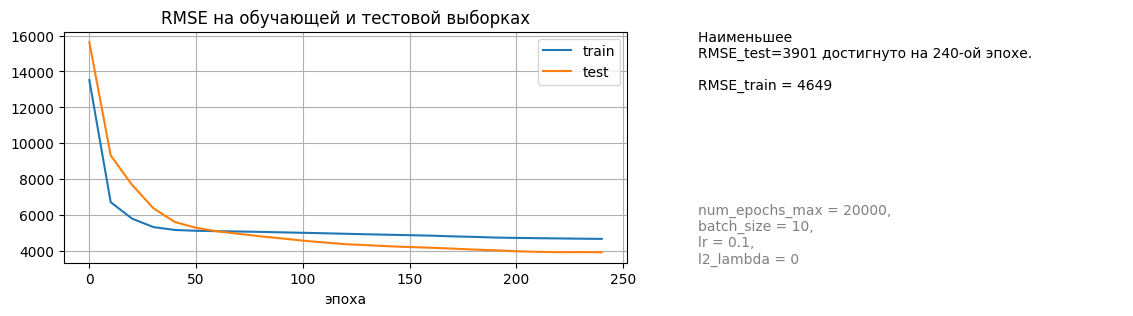

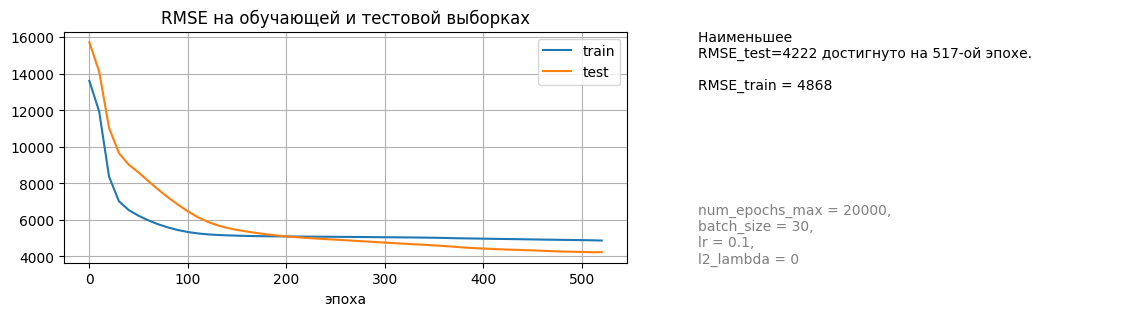

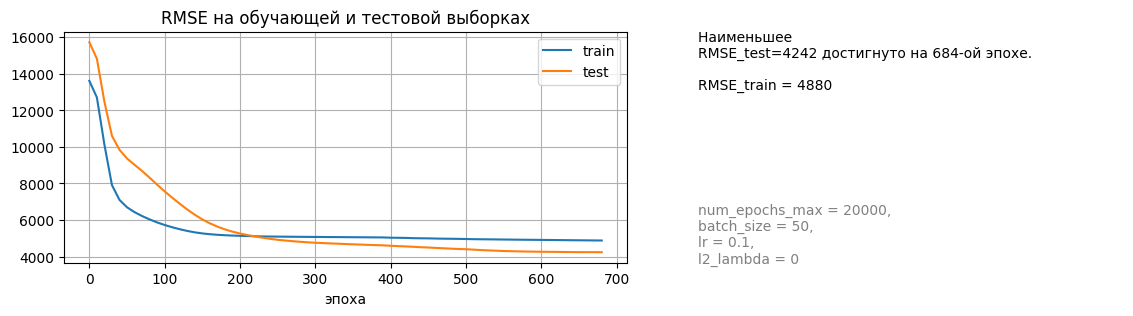

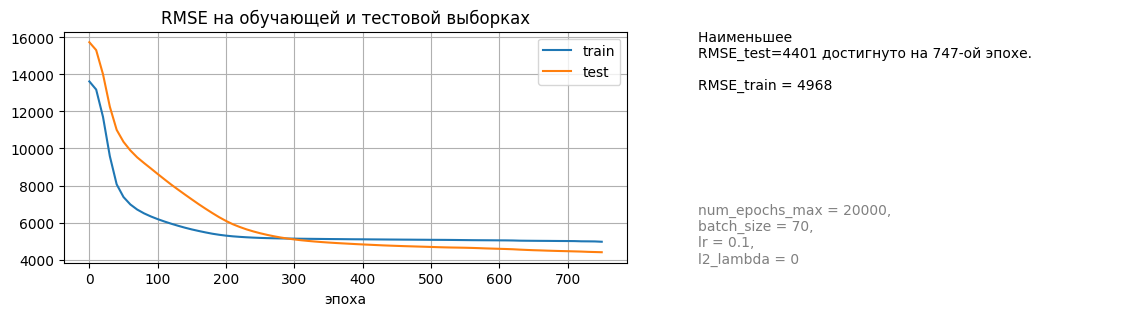

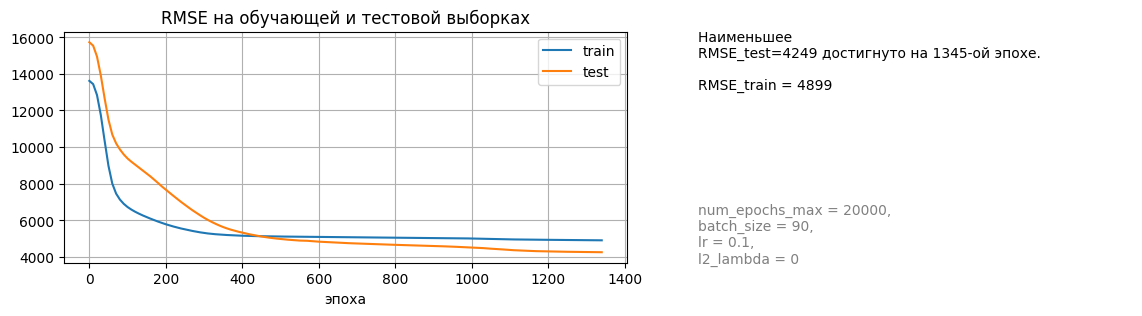

In [82]:
for b_size in range(10, 91, 20):
    
    model = Net(8,25,1)
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    batch_size = b_size
    num_epochs = 20000
    num_batches = ceil(len(X_train)/batch_size)
    
    neural_net()

Наименьший результат метрики качества с небольшим размером батча (10-30 объектов). Используем 30, как в baseline.

## Вывод

Сводная таблица

|№/тип эксперимента | Гиперпараметры | RMSE | Эпоха достижения |
| ---           | ---            | ---  | ---              |
| Вариант 1     | 8/3/1, Sigmoid, lr=0.1  | 10780 | 4608 |
| Вариант 2     | 8/25/1, Sigmoid, lr=0.1 | 8547 | 2419 |
| Вариант 3            | 8/25/1, Tanh, lr=2 | 7605 | 904 |
| <font color='blue'>Вариант 4</font>           | <font color='blue'>8/25/1, ReLU, lr=0.1</font> | <font color='blue'>3734</font> | <font color='blue'>1172</font> |
| Вариант 5           | 8/3/1, ReLU, lr=0.1 | 5697 | 479 |
| Вариант 6  | 8/25/5/1, ReLU, Tanh, lr=2 | 10742 | 345 |
| Вариант 7           | 8/5/25/1, ReLU, Tanh, lr=3 | 10736 | 67 |
| Вариант 8           | 8/6/3/1, ReLU, Tanh, lr=1 | 10748 | 794 |
| Вариант 9           | 8/10/3/1, Sigmoid, ReLU, lr=0.1 | 5985 | 181 |
|  Выбираем в качестве baseline<br> Вариант 4 |
| Инициализация параметров сети<br> равномерным распределением           | - | 3822 | 815 |
| Инициализация параметров сети<br> нормальным распределением           | - | 3785 | 830 |
|  Далее работаем с baseline<br> с нормальной инициализацией |
| Регуляризация весов           | l2_lambda = 0.0 | 3954 | 946 |
| -//-           | l2_lambda = 0.2 | 3791 | 772 |
| -//-           | l2_lambda = 0.4 | 4822 | 179 |
| -//-           | l2_lambda = 0.6 | 3919 | 687 |
| -//-           | l2_lambda = 0.8 | 3731 | 825 |
| -//-           | l2_lambda = 1.0 | 3876 | 949 |
| Batch normalization   | - | 4700 | 94 |
| Dropout           | p = 0.08 | 4384 | 558 |
| -//-           | p = 0.38 | 5246 | 180 |
| -//-           | p = 0.68 | 6304 | 163 |
| -//-           | p = 0.98 | 13295 | 31 |
| Batch size           | bs = 10 | 3901 | 240 |
| ---           | bs = 30 | 4222 | 517 |
| ---           | bs = 50 | 4242 | 684 |
| ---           | bs = 70 | 4401 | 747 |
| ---           | bs = 90 | 4249 | 1345 |

* В исходных данных отсутствуют полные дубликаты, пропуски и необъяснимые выбросы, противоречащие астрономии. Был ряд дубликатов в цвете звёзд, который обработан.
* Star type удалён из обучающей выборки, так как мультиколлинеарен признакам Absolute magnitude и Star color.
* Исходный датасет крайне маленький (240 объектов). Разбиваем его на две части train и test (0.75/0.25). Обучение проводилось на train, валидация на test. Из-за небольшого размера исходного датасета нет возможности вычленить из него 3-ю часть для единоразового тестирования отвалидированной модели.
* Улучшить метрику качества получилось в том числе благодаря тому, что в момент разбиения на train/test была проведена стратификация по цвету звезды.
* Для выбора базовой модели (baseline) проведено 9 экспериментов. Лучшую метрику качества RMSE (3734) показала архитектура 8/25/1, ReLU, lr=0.1.
* Были проведены попытки улучшить модель с помощью инструментов: инициализация параметров сети равномерным/нормальным распределением, регуляризация весов, BatchNorm, Dropout, Batch size.
* Ни один из используемых инструментов  не позволил повысить качество базовой модели.
* В производство рекомендуется модель baseline c нормальной инициализацией весов.